In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import contractions
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import nltk
import pickle
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2> Data Entry </h2>

In [2]:
filename = Path.cwd().parent.joinpath('data', 'interim', 'cleaned_2019.csv')
datatypes = {'charCount': 'int32',
             'wordcount': 'int32',
             'productionOffice': 'category',
             'pillarName': 'category',
             'type': 'category',
             'publication': 'category',
             'sectionName': 'category'}

In [3]:
df = pd.read_csv(filename, dtype = datatypes)

In [4]:
df = df[df['type'] == 'article']
df.drop('type', axis=1, inplace=True)

In [5]:
df['bodyText'] = df['bodyText'].astype(str)

In [6]:
df.webPublicationDate = pd.to_datetime(df.webPublicationDate)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75045 entries, 0 to 78385
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Unnamed: 0          75045 non-null  int64              
 1   sectionName         75045 non-null  category           
 2   webPublicationDate  75045 non-null  datetime64[ns, UTC]
 3   webTitle            75045 non-null  object             
 4   pillarName          74423 non-null  category           
 5   headline            75045 non-null  object             
 6   byline              73348 non-null  object             
 7   webUrl              75045 non-null  object             
 8   bodyText            75045 non-null  object             
 9   wordcount           75045 non-null  int32              
 10  publication         75045 non-null  category           
 11  charCount           75045 non-null  int32              
 12  productionOffice    75045 non-nu

In [8]:
def category_percentage(dataframe, column):
    '''
    parameter: column as string
    
    return: pandas.Series of percentages of total dataframe
    '''
    return round(dataframe[column].value_counts(sort=True, normalize=True)*100, 2)

Lets explore whether NLP can predict the pillar from the body of the article.

First, lets check our distribution of pillars:

World news                                             9.01
Opinion                                                8.90
Football                                               7.40
Politics                                               7.00
Sport                                                  6.80
                                                       ... 
Kids' travel guides                                    0.00
Indigenous Business Australia: Building communities    0.00
First Man: Home entertainment release                  0.00
Entertainment One: Stan & Ollie                        0.00
Xero: Digital Connectivity                             0.00
Name: sectionName, Length: 108, dtype: float64


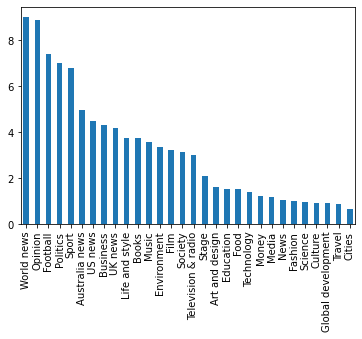

In [9]:
pillar_pc = category_percentage(df, 'sectionName')
print(pillar_pc)
pillar_pc.head(30).plot.bar()

News         49.36
Arts         18.64
Sport        14.32
Opinion       8.98
Lifestyle     8.71
Name: pillarName, dtype: float64


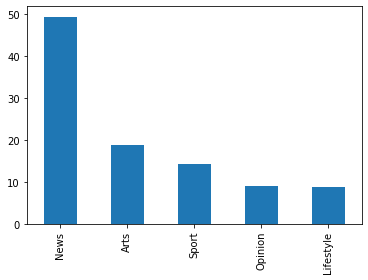

In [10]:
pillar_pc = category_percentage(df, 'pillarName')
print(pillar_pc)
pillar_pc.plot.bar()

News is the predominant pillar clearly.

(-100.0, 2000.0)

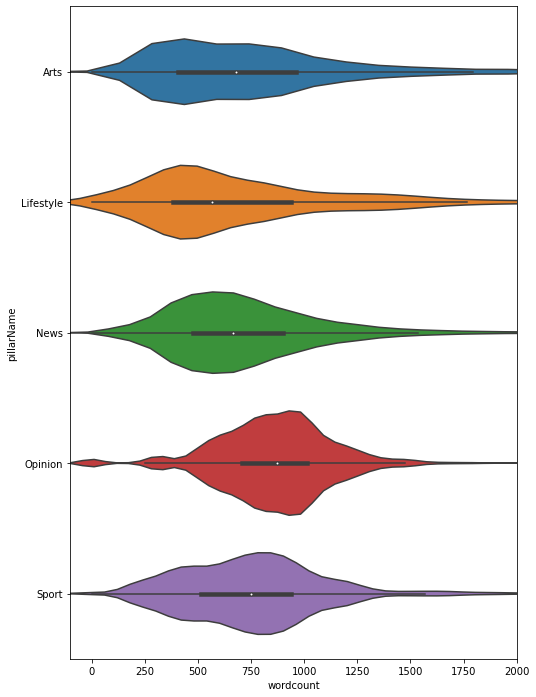

In [11]:
plt.figure(figsize = (8, 12))
sns.violinplot(y = 'pillarName', 
               x = 'wordcount', 
               data = df,
               orient='h')
plt.xlim(-100, 2000)

There is variation in the length of articles based on their pillars. 
- The opinion articles are most consistant in terms of article length and longest on average. 
- The distribution of opinion pieces is double peaked, with a smaller peak at approx 300 words. I assume these are editorial pieces.
- Sports and Arts pieces vary in length most substationally.
- Lifestyle content is generally the shortest in length.

<h2> Word tokenizing </h2>

In [12]:
string.punctuation.split()

['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']

In [13]:
stopwords
stopwords.words('english')[0:10] # Show some stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [14]:
lemmatizer = WordNetLemmatizer() 

In [15]:
def text_process(text):
    tokens = word_tokenize(text.lower())
    tokens = [contractions.fix(word) for word in tokens]
    tokens = [re.sub(r'\d+|\$|\£|\–|\’|\…|\”|\“', '', word) for word in tokens]
    tokens = [word for word in tokens if word not in string.punctuation]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [16]:
text = df.bodyText[2285]
tok = text_process(text)
print(tok)
print(text)

['wrong', 'describe', 'mp', 'john', 'mann', 'independent', 'though', 'nominated', 'non-affiliated', 'life', 'peer', 'remain', 'labour', 'mp', 'either', 'next', 'general', 'election', 'elevated', 'house', 'lord', 'minister', 'seek', 'opposition', 'mp', 'support', 'october', 'page', 'recently', 'corrected', 'article', 'include', 'egypt', 'tahrir', 'square', 'lockdown', 'regime', 'move', 'stifle', 'protest', 'fitness', 'tip', 'three', 'hiit', 'exercise', 'beginner', 'uproar', 'research', 'claim', 'red', 'meat', 'pose', 'health', 'risk']
• We were wrong to describe the MP John Mann as an independent. Though he has been nominated as a non-affiliated life peer he will remain a Labour MP until either the next general election or when he is elevated to the House of Lords (Minister seeks opposition MPs’ support, 2 October, page 9). • Other recently corrected articles include: Egypt’s Tahrir Square on lockdown as regime moves to stifle protests Fitness tips: three HIIT exercises for beginners Up

<h2> NMF Model </h2>

In [17]:
n_articles = 10000
df_train = df[:n_articles]

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10449
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Unnamed: 0          10000 non-null  int64              
 1   sectionName         10000 non-null  category           
 2   webPublicationDate  10000 non-null  datetime64[ns, UTC]
 3   webTitle            10000 non-null  object             
 4   pillarName          9898 non-null   category           
 5   headline            10000 non-null  object             
 6   byline              9793 non-null   object             
 7   webUrl              10000 non-null  object             
 8   bodyText            10000 non-null  object             
 9   wordcount           10000 non-null  int32              
 10  publication         10000 non-null  category           
 11  charCount           10000 non-null  int32              
 12  productionOffice    10000 non-nu

In [19]:
texts = df_train.bodyText.apply(text_process)

In [20]:
headlines = df_train.headline.values

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.9,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

In [22]:
tfidf = tfidf_vectorizer.fit_transform(texts)

In [23]:
tfidf_fn = np.array(tfidf_vectorizer.get_feature_names())

In [24]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=25)

In [25]:
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.pipeline import make_pipeline

scaler = MaxAbsScaler()
normalizer = Normalizer()

model = make_pipeline(scaler, nmf, normalizer)

In [26]:
norm_features = model.fit_transform(tfidf)

In [45]:
# save the model to disk
filename = 'norm_nmf_'+str(n_articles)+'.sav'
pickle.dump(model, open(filename, 'wb'))
filename = 'nmf_'+str(n_articles)+'.sav'
pickle.dump(model, open(filename, 'wb'))

In [46]:
filename = Path.cwd().parent.joinpath('data', 'interim', 'training_data_'+str(n_articles)+'.csv')
df_train.to_csv(filename)

In [27]:
norm_features

array([[0.09309941, 0.        , 0.37266795, ..., 0.        , 0.        ,
        0.3184223 ],
       [0.00515526, 0.        , 0.        , ..., 0.37580229, 0.70834841,
        0.02141798],
       [0.        , 0.        , 0.25990115, ..., 0.37078548, 0.22094467,
        0.36187847],
       ...,
       [0.12951515, 0.        , 0.        , ..., 0.        , 0.        ,
        0.05865834],
       [0.14790116, 0.        , 0.32409343, ..., 0.        , 0.06039232,
        0.0787775 ],
       [0.        , 0.00074382, 0.27470839, ..., 0.        , 0.03380843,
        0.        ]])

In [28]:
features = pd.DataFrame(norm_features, index=headlines)

In [29]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Doctors warn of danger of 'feather duvet lung',0.093099,0.0,0.372668,0.000000,0.000000,0.000000,0.305717,0.258335,0.000000,0.500582,...,0.000000,0.052604,0.196083,0.0,0.043019,0.501591,0.164763,0.000000,0.000000,0.318422
California home to 91 of America's 100 most expensive zip codes,0.005155,0.0,0.000000,0.000000,0.000000,0.000000,0.079222,0.000000,0.095998,0.179864,...,0.000000,0.184182,0.000000,0.0,0.000000,0.000000,0.396818,0.375802,0.708348,0.021418
'Meth. We're on it' – South Dakota's new public health ads raise eyebrows,0.000000,0.0,0.259901,0.000000,0.000000,0.000000,0.124256,0.426326,0.194807,0.501044,...,0.112226,0.059055,0.000000,0.0,0.000000,0.248167,0.000000,0.370785,0.220945,0.361878
"Labour pledges to close loopholes used to hunt foxes, hares and deer",0.004270,0.0,0.435103,0.000879,0.419595,0.000000,0.313960,0.000000,0.000000,0.270215,...,0.055358,0.014655,0.000000,0.0,0.382218,0.000000,0.000000,0.236851,0.036331,0.000000
England’s Marcus Rashford back in the goal groove after confidence takes a hit,0.068767,0.0,0.185044,0.003341,0.000000,0.344867,0.000000,0.391030,0.000000,0.044536,...,0.000000,0.000000,0.741586,0.0,0.076317,0.000000,0.209967,0.000000,0.000000,0.294074


<h3> Similarities </h3>
    
Selects other articles most similar in content according to the model. 

In [47]:
article = features.iloc[1460]
similarities = features.dot(article)
print(similarities.nlargest(10))

Families hit out at London gasworks redevelopment                              1.000000
Electric cars could be charged in 10 minutes in future, finds research         0.916052
Mind the gender pay gap: Berlin women to get public transport discount         0.904898
'This is meant to be a caring country?': refugees battle the cold in Madrid    0.904814
Grenfell inquiry chair demands end to 'stay put' advice for all high-rises     0.904096
Woman 'poses as dead cyclist's aunt' to oppose new London bike lane            0.899339
Ebola now curable after trials of drugs in DRC, say scientists                 0.890535
US pastor runs network giving 50,000 Ugandans bleach-based 'miracle cure'      0.888133
'Inhuman conditions': life in factory making Spice Girls T-shirts              0.886162
Homeless protesters storm council building in Chester                          0.882931
dtype: float64


<h3> Topic Modelling </h3>

In [31]:
for i, topic in enumerate(nmf.components_):
    print("\nTopic {}: {}".format(i + 1, ", ".join(
        [str(x) for x in tfidf_fn
         [topic.argsort()[:-15-1:-1]]])))


Topic 1: even, one, might, much, seems, yet, could, least, nothing, way, rather, though, perhaps, almost, another

Topic 2: gu com, com letters, guardian letter, letter click, click visit, visit gu, letters, join debate, email guardian, com read, guardian letters, debate email, letters theguardian, print edition, reader click

Topic 3: said, added, said would, would, told, asked, adding, thursday, monday, friday, one, could, said could, also said, saying

Topic 4: guardianbookshop, guardianbookshop com, free uk, go guardianbookshop, online order, amp online, copy go, com call, call free, order copy, phone order, order phone, min amp, order min, order

Topic 5: theresa, deal, theresa may, minister, may, brexit, prime, prime minister, parliament, common, vote, mp, would, government, no deal

Topic 6: season, league, club, player, manager, manchester united, premier, premier league, manchester, manchester city, champion, team, united, football, liverpool

Topic 7: case, police, court, in

In [32]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

In [33]:
topics_df = topic_table(nmf, tfidf_fn, 15).T

In [34]:
topics_df['topics'] = topics_df.apply(lambda x: [', '.join(x)][0], axis=1) 

In [35]:
topics_df = pd.DataFrame({'topic number': topics_df.index, 'topic':topics_df.topics})

In [36]:
topics_df

,topic number,topic
0,0,"even, one, might, much, seems, yet, could, lea..."
1,1,"gu com, com letters, guardian letter, letter c..."
2,2,"said, added, said would, would, told, asked, a..."
3,3,"guardianbookshop, guardianbookshop com, free u..."
4,4,"theresa, deal, theresa may, minister, may, bre..."
5,5,"season, league, club, player, manager, manches..."
6,6,"case, police, court, including, investigation,..."
7,7,"know, thing, like, think, get, make, something..."
8,8,"trump, president, donald, donald trump, presid..."
9,9,"need, people, child, many, provide, service, s..."


In [37]:
highest_topics = pd.DataFrame(norm_features.argmax(axis=1), columns=['topic number'])
print(highest_topics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   topic number  10000 non-null  int64
dtypes: int64(1)
memory usage: 78.2 KB
None


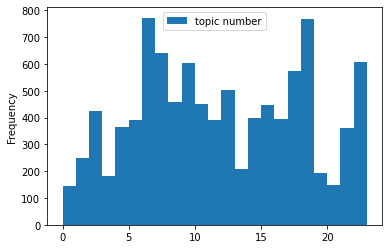

In [53]:
highest_topics.plot(kind='hist', bins=range(0,24))

In [38]:
highest_topics = highest_topics.merge(topics_df, on='topic number', how='left')
print(highest_topics.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   topic number  10000 non-null  int64 
 1   topic         10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 234.4+ KB
None


In [39]:
df_headline = pd.DataFrame(headlines, columns=['headline'])
print(df_headline.info())
info_df = df_train[['sectionName', 'pillarName', 'headline']]
print(info_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10449
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sectionName  10000 non-null  category
 1   pillarName   9898 non-null   category
 2   headline     10000 non-null  object  
dtypes: category(2), object(1)
memory usage: 181.8+ KB
None


In [40]:
df_article_topic = df_headline.join(highest_topics)
print(df_article_topic.info())

df_article_topic = df_article_topic.merge(info_df, on='headline', how='inner')
print(df_article_topic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      10000 non-null  object
 1   topic number  10000 non-null  int64 
 2   topic         10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12152 entries, 0 to 12151
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   headline      12152 non-null  object  
 1   topic number  12152 non-null  int64   
 2   topic         12152 non-null  object  
 3   sectionName   12152 non-null  category
 4   pillarName    12050 non-null  category
dtypes: category(2), int64(1), object(2)
memory usage: 409.5+ KB
None


In [41]:
df_article_topic = df_article_topic.drop_duplicates('headline')

In [42]:
df_article_topic

,headline,topic number,topic,sectionName,pillarName
0,Doctors warn of danger of 'feather duvet lung',20,"form, using, trouble, tell, share, please, ter...",Science,News
1,California home to 91 of America's 100 most ex...,23,"new, zealand, new zealand, york, new york, wor...",US news,News
2,'Meth. We're on it' – South Dakota's new publi...,9,"need, people, child, many, provide, service, s...",US news,News
3,Labour pledges to close loopholes used to hunt...,2,"said, added, said would, would, told, asked, a...",Politics,News
4,England’s Marcus Rashford back in the goal gro...,17,"back, goal, second, team, england, world, fina...",Football,Sport
...,...,...,...,...,...
12147,"US adds 130,000 jobs August, dropping below ex...",10,"company, executive, chief, chief executive, bn...",Business,News
12148,"Let’s move to Ormeau, Belfast: catch it before...",14,"around, make, one, back, small, add, little, p...",Money,Lifestyle
12149,Waiting for the Barbarians review – Johnny Dep...,18,"film, show, play, cast, played, like, story, s...",Film,Arts
12150,Gauke: Johnson risks millions of votes with 'F...,4,"theresa, deal, theresa may, minister, may, bre...",Politics,News


<h3> Comparing model topics with labeled sections..</h3>

Topic 18 appears to be related to media, specifically TV/movie/theatre and music. 
Exploring the newspaper's labeled sections shows that the model assigned topic is consistent with the actual. 

['film, show, play, cast, played, like, story, set, drama, album, song, director, production, role, star']


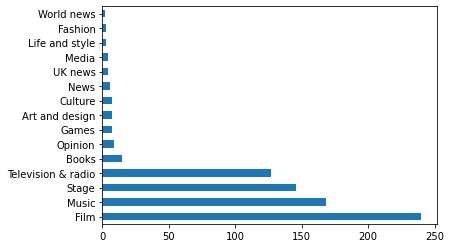

In [68]:
df_article_topic[df_article_topic['topic number'] ==
                 18].sectionName.value_counts().head(15).plot(kind='barh')
print(df_article_topic[df_article_topic['topic number'] == 18].topic.unique())

Topic 13 appears to be related to Brexit based on keywords.
Exploring the newspaper's labelled sections shows that the model assigned topic is consistent with the actual, with lots of politics and opinion pieces. 

['uk, eu, brexit, ireland, deal, british, northern ireland, would, irish, northern, european, country, britain, border, could']


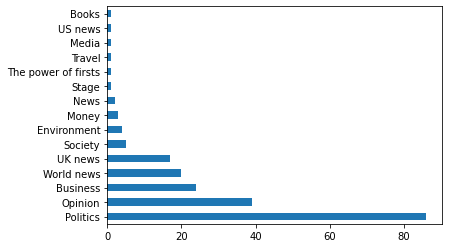

In [69]:
df_article_topic[df_article_topic['topic number'] ==
                 13].sectionName.value_counts().head(15).plot(kind='barh')
print(df_article_topic[df_article_topic['topic number'] == 13].topic.unique())

['theresa, deal, theresa may, minister, may, brexit, prime, prime minister, parliament, common, vote, mp, would, government, no deal']


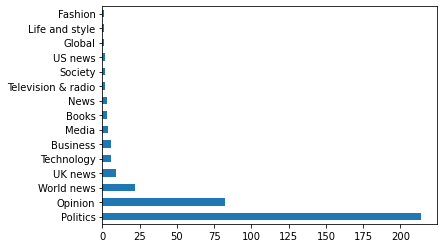

In [67]:
df_article_topic[df_article_topic['topic number'] ==
                 4].sectionName.value_counts().head(15).plot(kind='barh')
print(df_article_topic[df_article_topic['topic number'] == 4].topic.unique())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


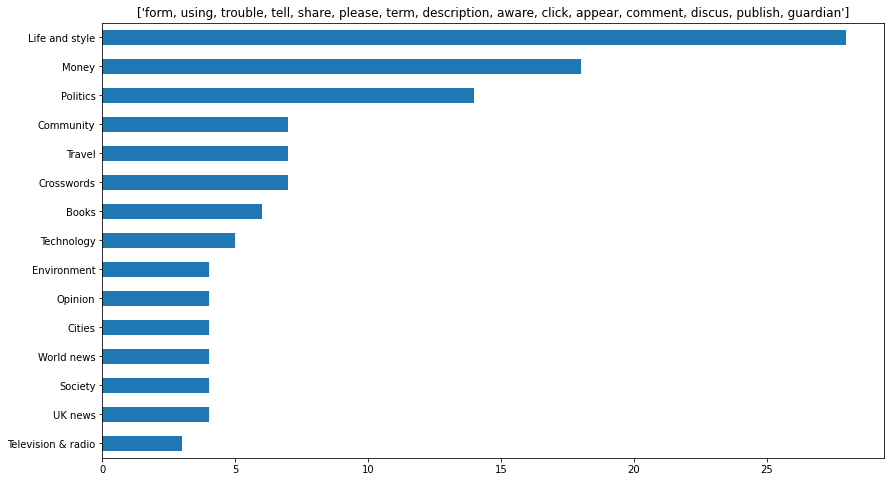

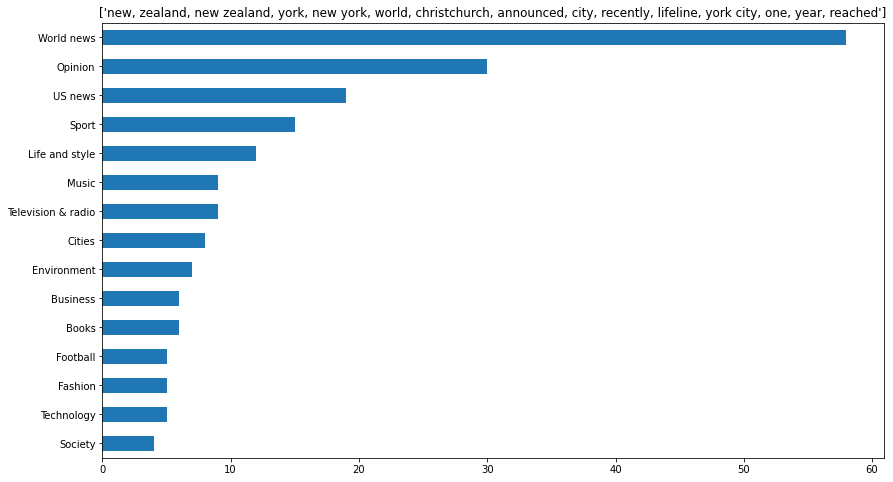

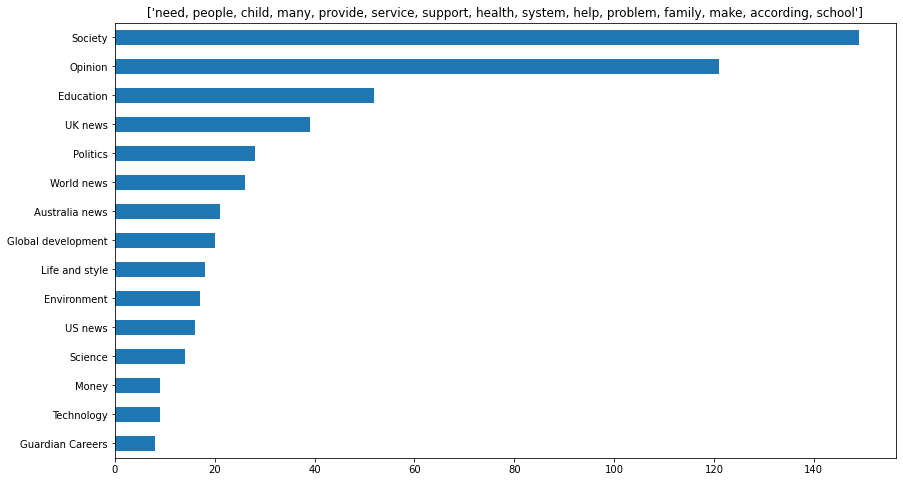

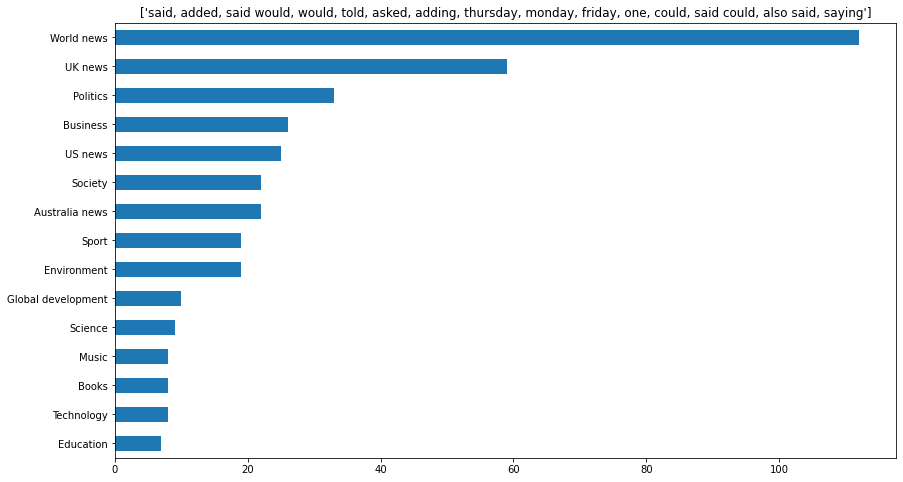

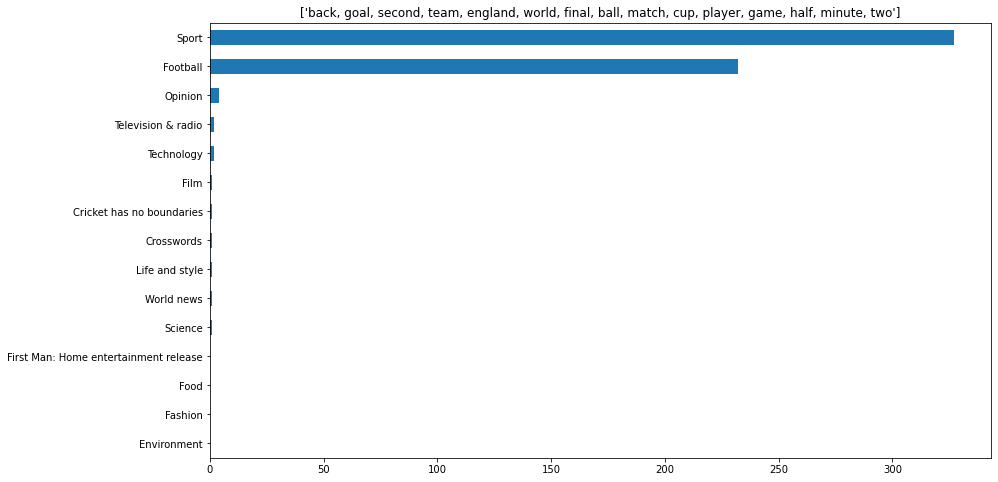

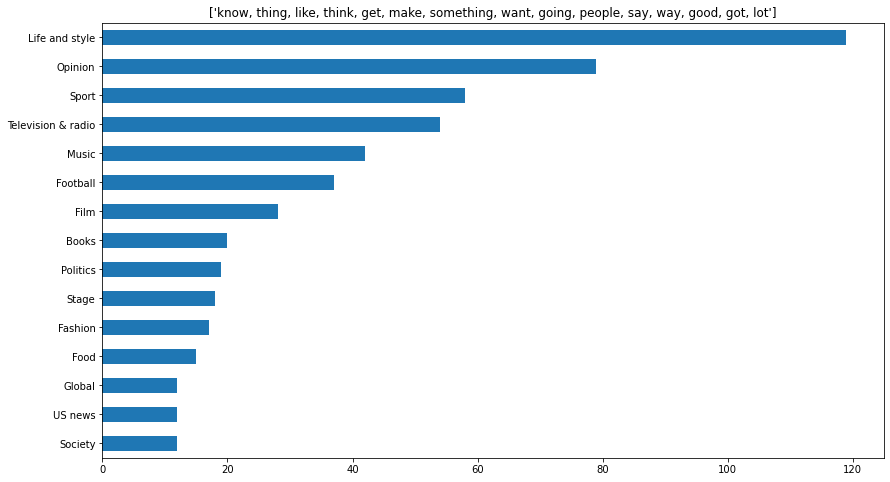

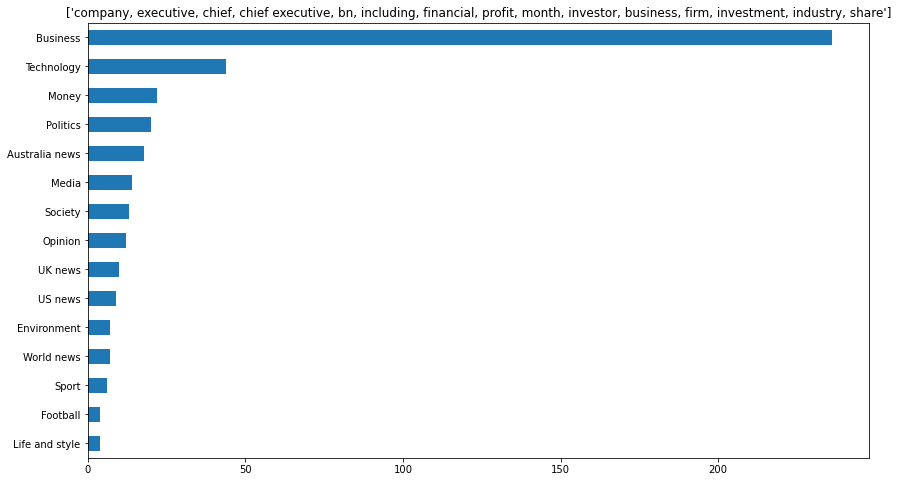

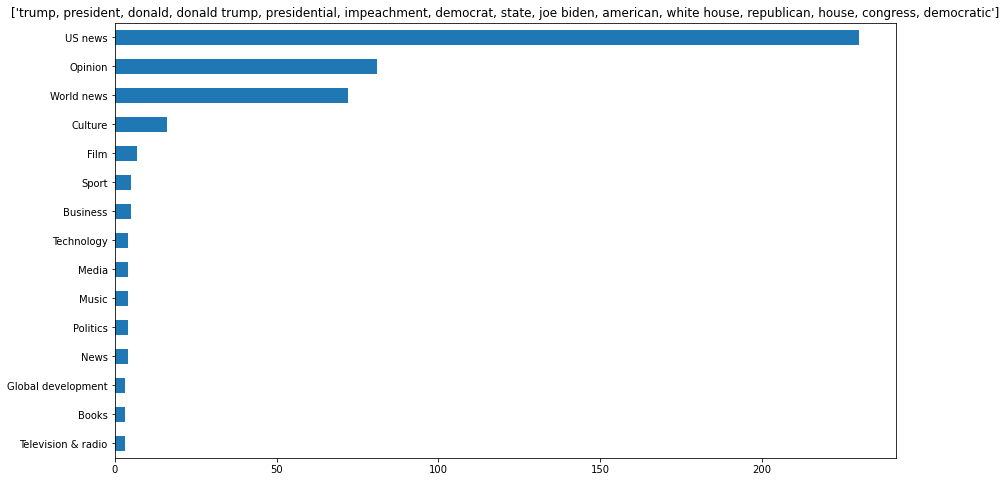

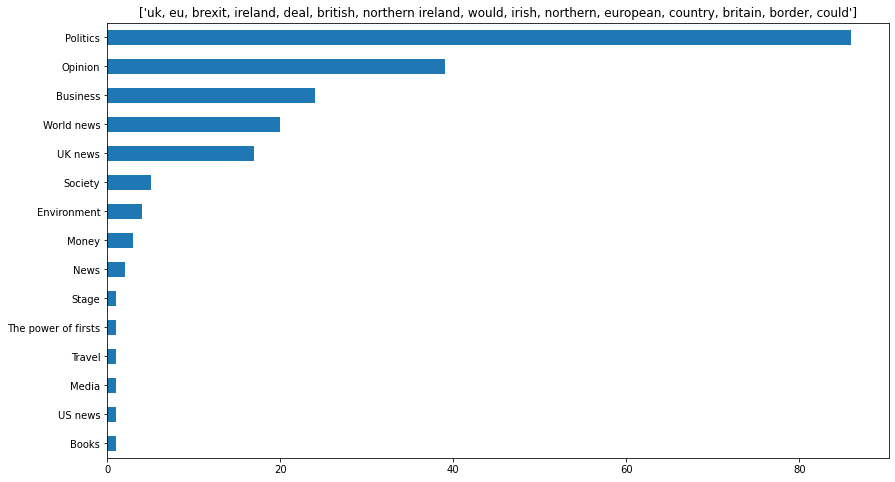

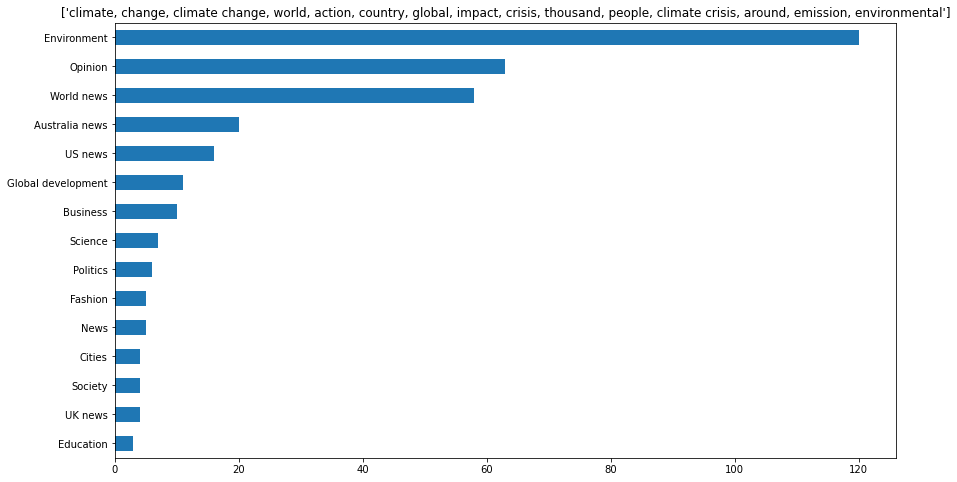

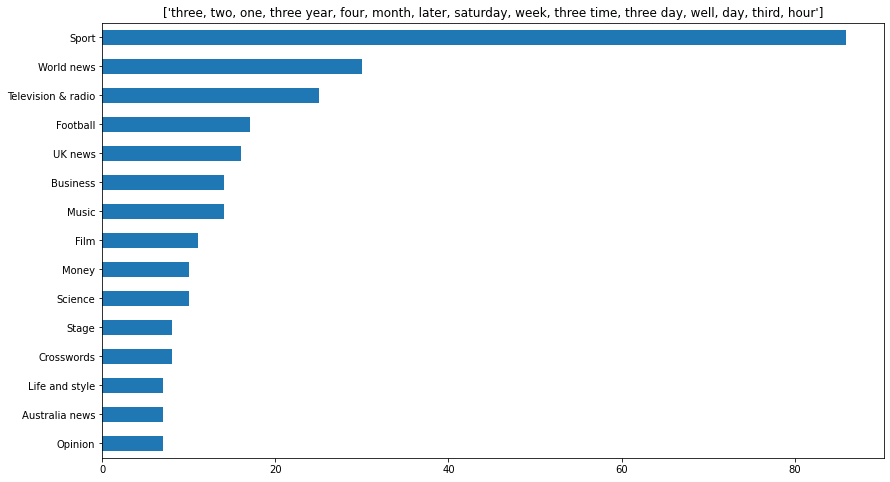

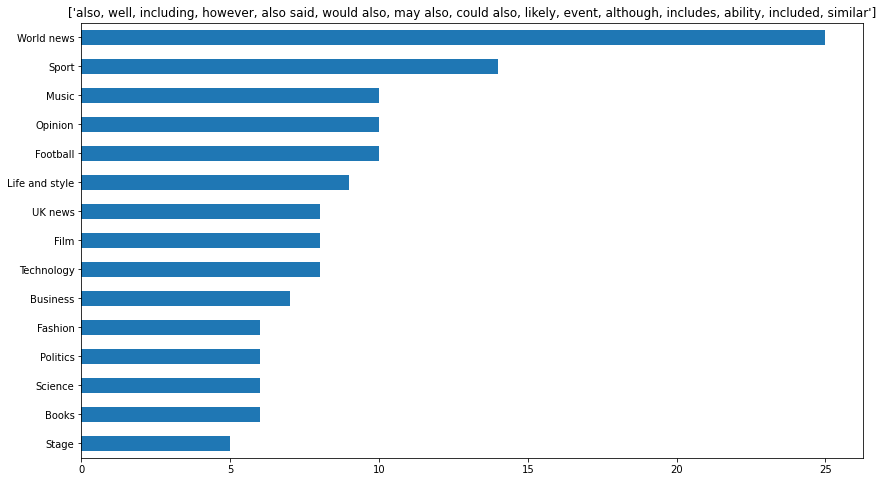

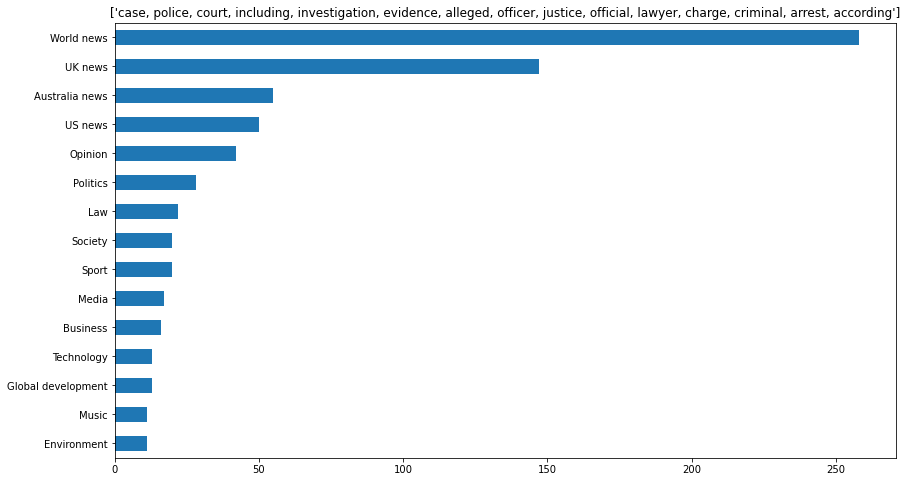

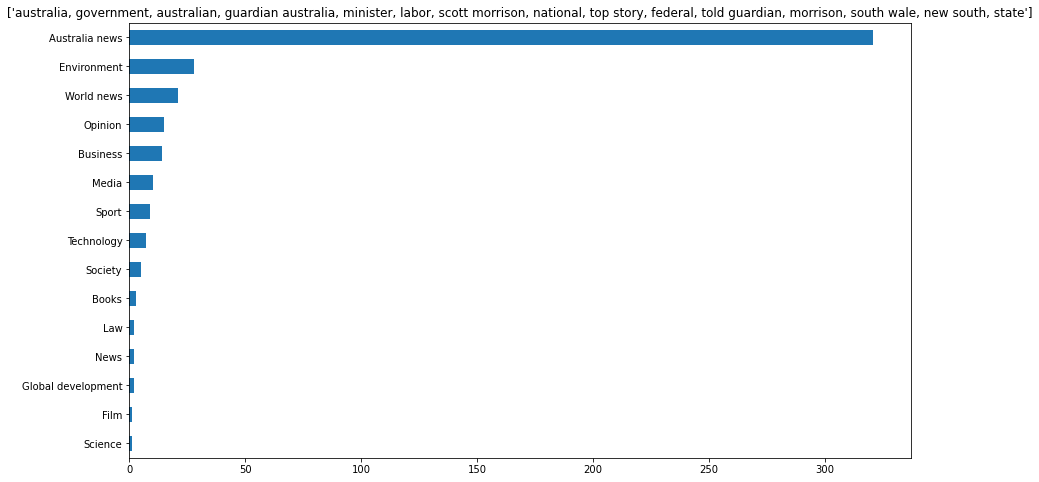

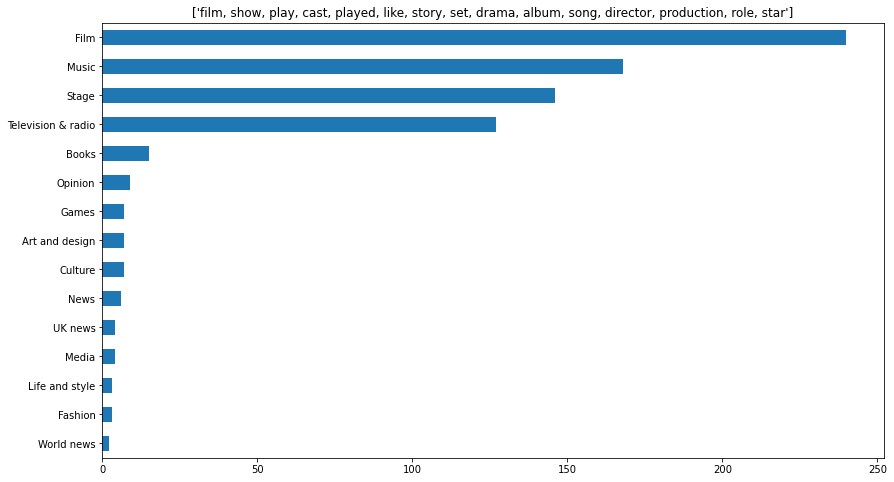

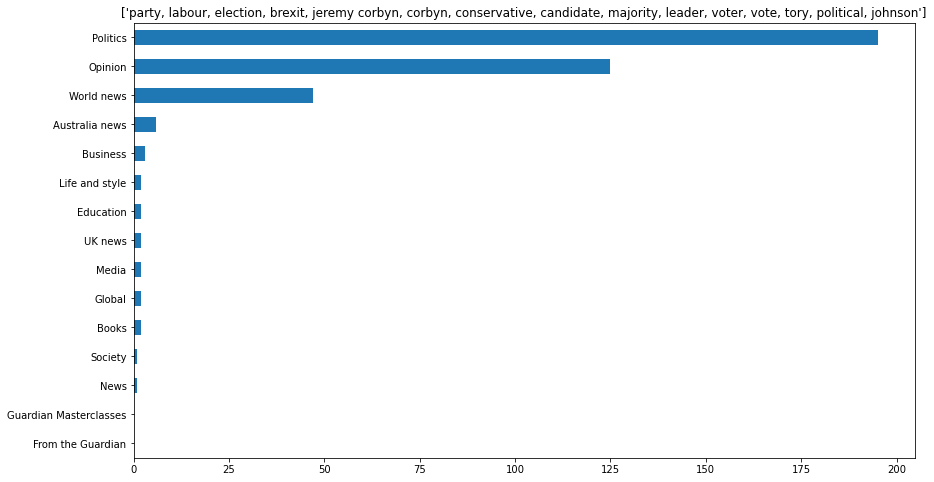

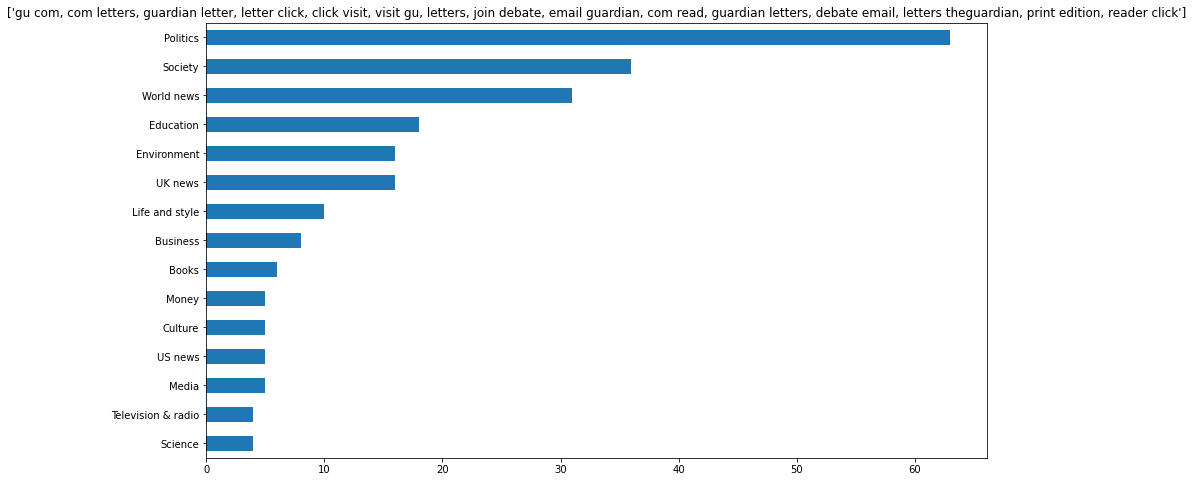

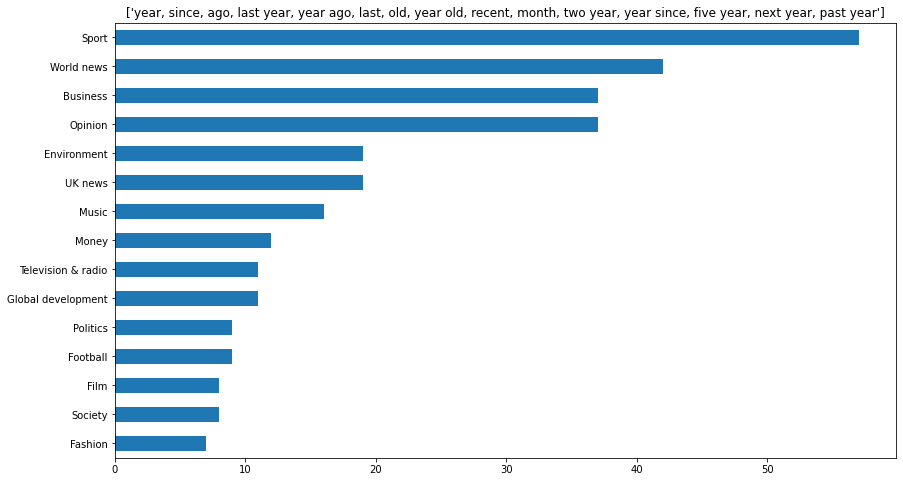

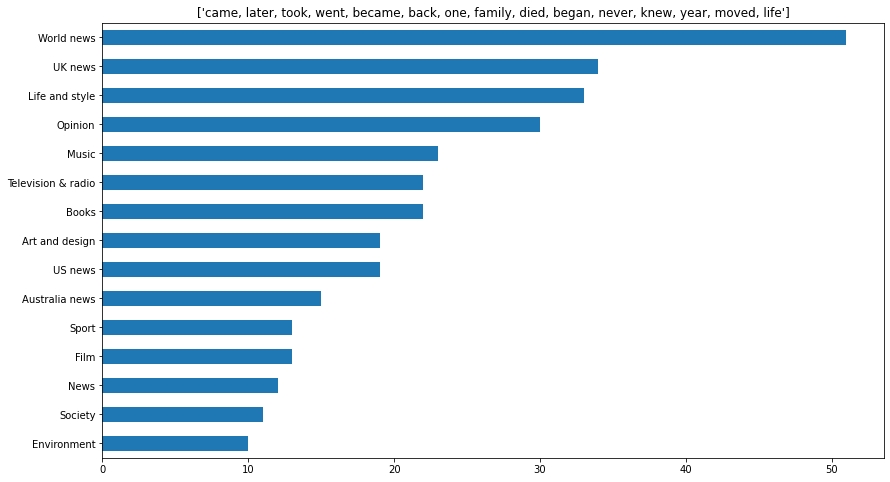

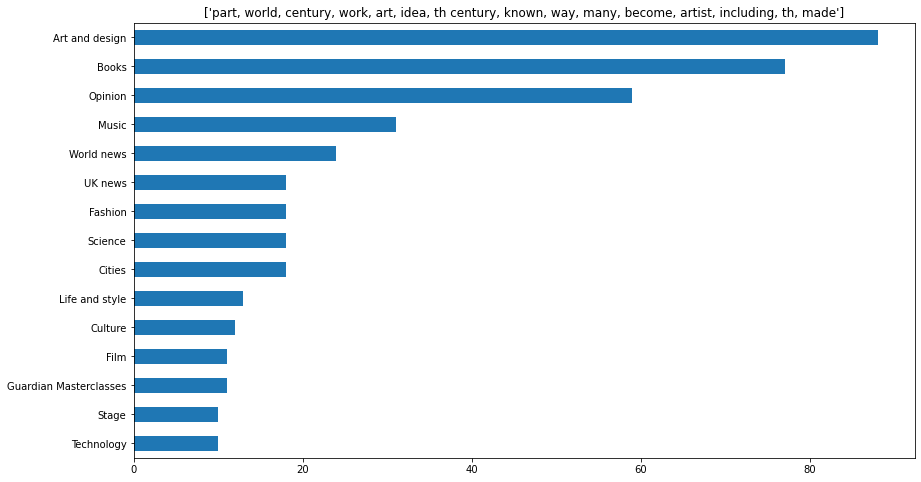

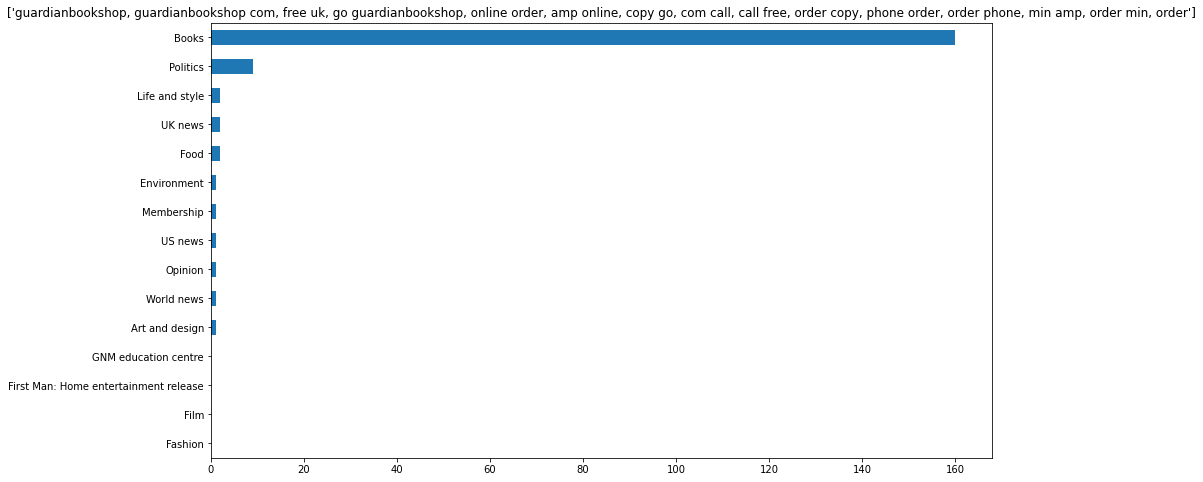

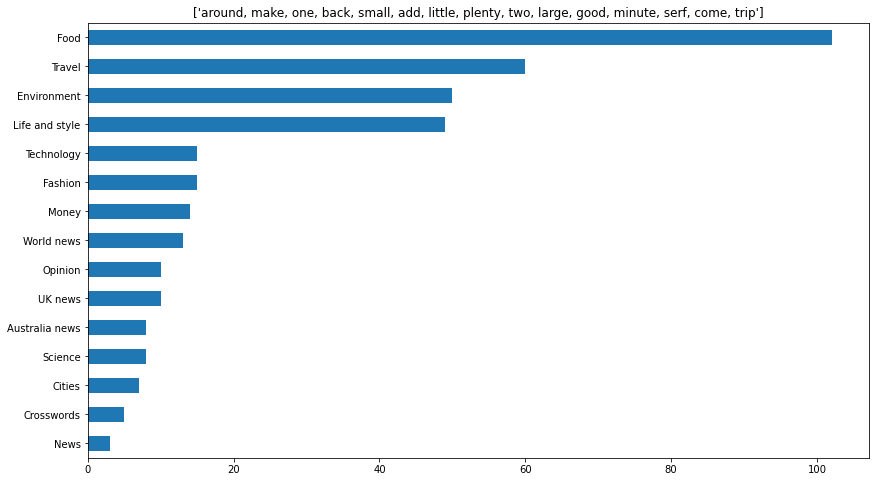

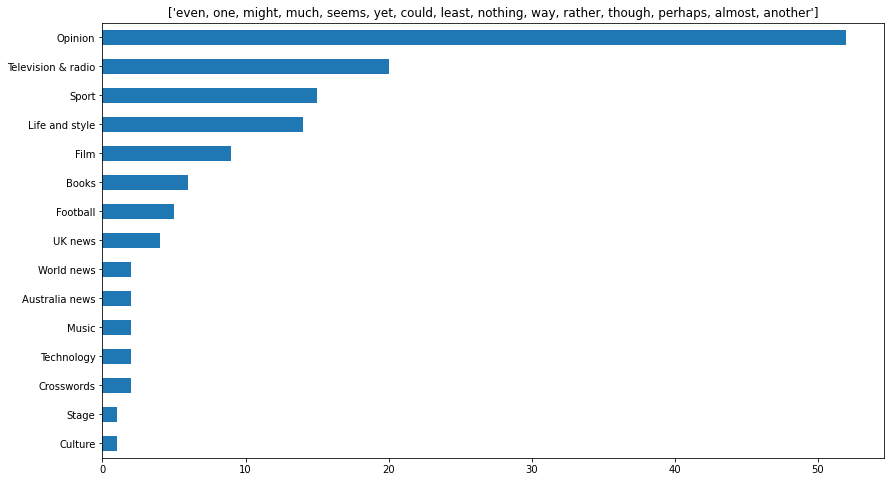

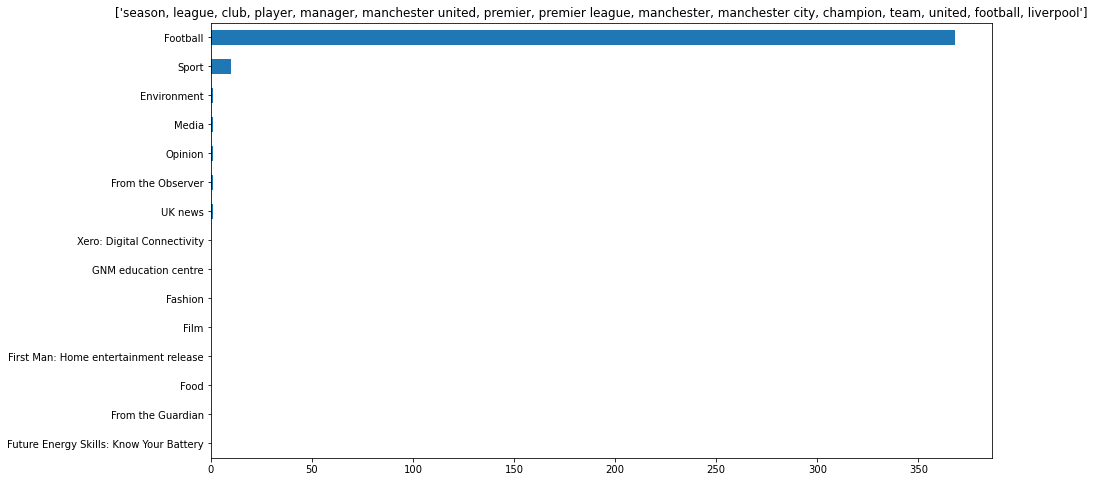

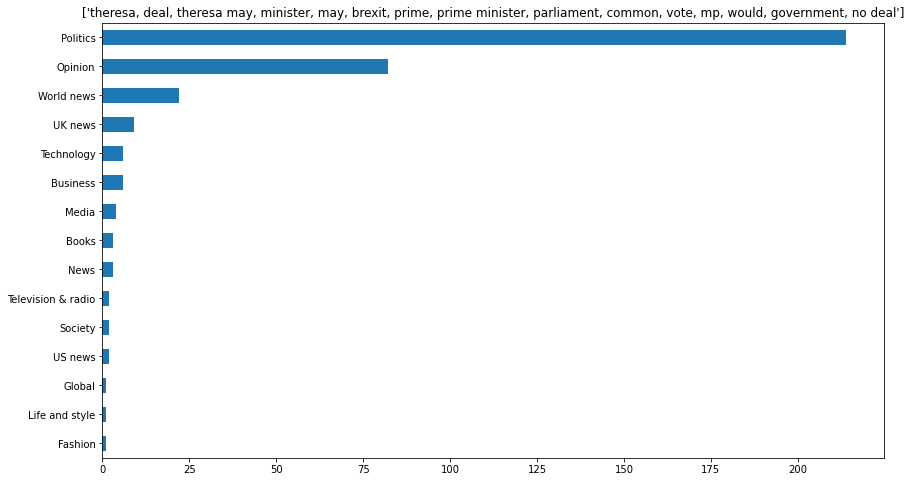

In [94]:
for topic_id in df_article_topic['topic number'].unique():
    fig, ax = plt.subplots(figsize=(14, 8))
    df_article_topic[df_article_topic['topic number'] ==
                     topic_id].sectionName.value_counts().head(15).plot(kind='barh', ax=ax)
    plt.title(
        df_article_topic[df_article_topic['topic number'] == topic_id].topic.unique())
    ax.invert_yaxis()
    filename = Path.cwd().parent.joinpath('reports', 'figures',
                                          'section_topic_'+str(topic_id)+'.png')
    plt.savefig(filename)

<h4>Next:</h4> 

- Residuals
- Predict on unseen data